In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sympy as sp
from sympy import pi


In [3]:
DOF = 5
q1, q2, q3, q4, q5 = sp.symbols('q1 q2 q3 q4 q5')

# Value of pi from the symbolic library for convenience
DH_params = []

DH_params.append([q1,pi/2,0,170.5])
DH_params.append([q2,0,83,0])
DH_params.append([q3, 0, 83, 0])
DH_params.append([q4+(pi/2),pi/2, 0, 0])
DH_params.append([q5, 0, 0, 188.5])
DH_params

[[q1, pi/2, 0, 170.5],
 [q2, 0, 83, 0],
 [q3, 0, 83, 0],
 [q4 + pi/2, pi/2, 0, 0],
 [q5, 0, 0, 188.5]]

In [4]:
# Using the combined DH transformation matrix
def DH_trans_matrix(params):
    
    theta, alpha, a , d = (params[0], params[1], params[2], params[3])
    
    mat = sp.Matrix([[sp.cos(theta), -1*sp.sin(theta)*sp.cos(alpha), sp.sin(theta)*sp.sin(alpha),    a*sp.cos(theta)],
                    [sp.sin(theta), sp.cos(theta)*sp.cos(alpha),    -1*sp.cos(theta)*sp.sin(alpha), a*sp.sin(theta)],
                    [0,             sp.sin(alpha),                  sp.cos(alpha),                  d],
                    [0,             0,                              0,                              1]])
    
    return mat

In [5]:
# Get the transformations from the origin to each of the joints and the end effector
def joint_transforms(DH_params):
    transforms = []

    transforms.append(sp.eye(4)) #Assuming the first first joint is at the origin
    #this is also the step I should think of for the second arm

    for el in DH_params:

        transforms.append(DH_trans_matrix(el))

    return transforms


In [6]:
def trans_EF_eval(joints, DH_params):  # This is forward kinematics
    
    # Convert to list if it's an ndarray
    if (isinstance(joints, np.ndarray)):
        joints = joints.flatten().tolist()
    
    transforms = joint_transforms(DH_params)

    trans_EF = transforms[0]

    for mat in transforms[1:]:

        trans_EF = trans_EF * mat
    
    trans_EF_cur = trans_EF
    
    trans_EF_cur = trans_EF_cur.subs(q1, joints[0])
    trans_EF_cur = trans_EF_cur.subs(q2, joints[1])
    trans_EF_cur = trans_EF_cur.subs(q3, joints[2])
    trans_EF_cur = trans_EF_cur.subs(q4, joints[3])
    trans_EF_cur = trans_EF_cur.subs(q5, joints[4])
    
    return trans_EF_cur

In [7]:
# This is just for visualizing the robot

def plot_pose(joints, DH_params):
    
    # Convert to list if it's an ndarray
    if (isinstance(joints, np.ndarray)):
        joints = joints.flatten().tolist()
        
    transforms = joint_transforms(DH_params)

    trans_EF = trans_EF_eval(joints, DH_params)
    
    pos_EF = trans_EF[0:3,3]
    xs = []
    ys = []
    zs = []
    # This might be repeating step for the visualization I have to get the each transformation step and append i the x,y,z position 
    for joint in range(DOF):

        trans_joint = transforms[0]

        for mat in transforms[1:joint+1]:

            trans_joint = trans_joint*mat

        pos_joint = trans_joint[0:3,3]
        
        pos_joint = pos_joint.subs(q1, joints[0])
        pos_joint = pos_joint.subs(q2, joints[1])
        pos_joint = pos_joint.subs(q3, joints[2])
        pos_joint = pos_joint.subs(q4, joints[3])
        pos_joint = pos_joint.subs(q5, joints[4])
        
        xs.append(pos_joint[0])
        ys.append(pos_joint[1])
        zs.append(pos_joint[2])  
    
    # In the last I am adding the end effector position  
    xs.append(pos_EF[0])
    ys.append(pos_EF[1])
    zs.append(pos_EF[2])
            
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.set_xlim3d(-100,100)
    ax.set_ylim3d(-100,100)
    ax.set_zlim3d(0, 400)

    
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    
    ax.plot(xs, ys, zs)
    ax.scatter(xs, ys, zs, c='red', marker='o', s=50)  # Add dots for each joint
    for i in range(len(xs)):
        ax.text(xs[i], ys[i], zs[i], f'J{i}', fontsize=10)


Matrix([
[ 0,  0, -1, -271.5],
[ 0, -1,  0,      0],
[-1,  0,  0,  253.5],
[ 0,  0,  0,      1]])

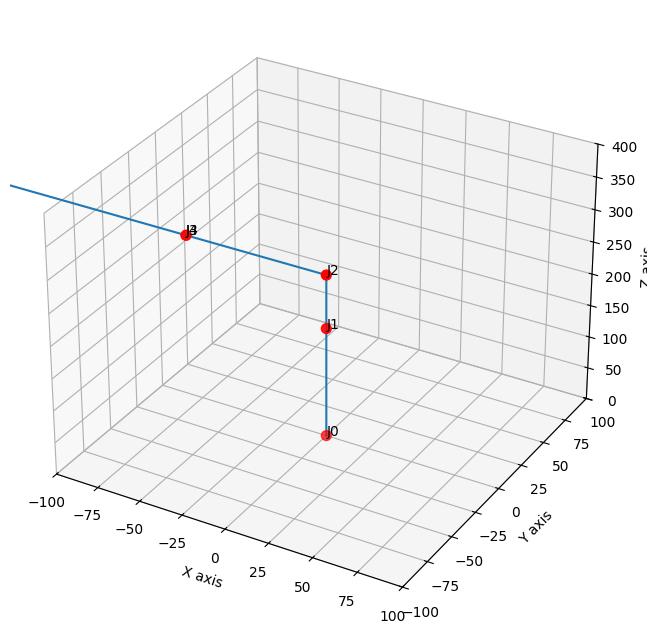

In [8]:
# This is just for testing the robot plotting mechanism

joints = np.array([0,pi/2,pi/2,0,0])

plot_pose(joints, DH_params)
trans_EF_eval(joints, DH_params)

## Now writing the code for the inverse kinematics using the 
DLS(Damped Least Squares ) method which is commonly used 

In [17]:
def joint_limits(joints):
    # Convert degree limits to radians　this is from the yahboom specification from yahboom simulation
    limits = [
        (0, pi),           # J1: 0° to 180°
        (0, pi),           # J2: 0° to 180°
        (0, pi),           # J3: 0° to 180°
        (0, pi),           # J4: 0° to 180°
        (0, 3*pi/2)        # J5: 0° to 270°
    ]

    # Clamp each joint to its corresponding limit
    for i in range(len(limits)):
        joints[i] = max(min(joints[i], limits[i][1]), limits[i][0])
    
    return joints

# def joint_limits(joints):
#     # Convert degree limits to radians　this is from the yahboom specification from yahboom simulation
#     limits = [
#         (-pi/2, pi/2),           # J1: 0° to 180°
#         (-pi/2, pi/2),           # J2: 0° to 180°
#         (-pi/2, pi/2),           # J3: 0° to 180°
#         (-pi/2, pi/2),           # J4: 0° to 180°
#         (-pi/2, pi/2)        # J5: 0° to 270°
#     ]

#     # Clamp each joint to its corresponding limit
#     for i in range(len(limits)):
#         joints[i] = max(min(joints[i], limits[i][1]), limits[i][0])
    
#     return joints

In [18]:
# joints_init is the current joint values for the robot
# target is the desired transformation matrix at the end effector
# set no_rotation to true if you only care about end effector position, not rotation
# set joint_lims to false if you want to allow the robot to ignore joint limits
# This is currently super slow since it's using all symbolic math
def i_kine(joints_init, target, DH_params, error_trace=False, no_rotation=False, joint_lims=True):
    
    joints = joints_init
    
    xr_desired = target[0:3,0:3]
    xt_desired = target[0:3,3]
    
    x_dot_prev = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
        
    e_trace = []
    
    iters = 0
    
    print("Finding symbolic jacobian")
    
    # We only do this once since it's computationally heavy
    jacobian_symbolic = jacobian_expr(DH_params)
    
    print("Starting IK loop")
    
    final_xt = 0
    
    while(1):
        
        jac = jacobian_subs(joints, jacobian_symbolic)
        
        jac = np.array(jac).astype(np.float64)
        
        trans_EF_cur = trans_EF_eval(joints, DH_params)
                
        trans_EF_cur = np.array(trans_EF_cur).astype(np.float64)
        
        
        xr_cur = trans_EF_cur[0:3,0:3]
        xt_cur = trans_EF_cur[0:3,3]
        
        final_xt = xt_cur
                
        xt_dot = xt_desired - xt_cur
        
        
        # Find error rotation matrix
        R = xr_desired @ xr_cur.T
        
                            
        # convert to desired angular velocity
        v = np.arccos((R[0,0] + R[1,1] + R[2,2] - 1)/2)
        r = (0.5 * sin(v)) * np.array([[R[2,1]-R[1,2]],
                                       [R[0,2]-R[2,0]],
                                       [R[1,0]-R[0,1]]])
        
        
        # The large constant just tells us how much to prioritize rotation
        xr_dot = 200 * r * sin(v)
        
        # use this if you only care about end effector position and not rotation
        if (no_rotation):
            
            xr_dot = 0 * r
        
        xt_dot = xt_dot.reshape((3,1))
                
        x_dot = np.vstack((xt_dot, xr_dot))
                
        x_dot_norm = np.linalg.norm(x_dot)
        
        #print(x_dot_norm)
                
        if (x_dot_norm > 25):
            
            x_dot /= (x_dot_norm/25)
            
        x_dot_change = np.linalg.norm(x_dot - x_dot_prev)
                    
        # This loop now exits if the change in the desired movement stops changing
        # This is useful for moving close to unreachable points
        if (x_dot_change < 0.005):
            
            break
            
        x_dot_prev = x_dot
            
        e_trace.append(x_dot_norm)
            
        Lambda = 12
        Alpha = 1
                        
        joint_change = Alpha * np.linalg.inv(jac.T@jac + Lambda**2*np.eye(DOF)) @ jac.T @ x_dot
        
        joints += joint_change
        
        if (joint_lims): joints = joint_limits(joints)
        
        iters += 1
                
    print("Done in {} iterations".format(iters))
    
    print("Final position is:")
    print(final_xt)
        
    return (joints, e_trace) if error_trace else joints

In [19]:
joints = np.array([[pi/2],[pi/2],[pi/2],[pi/2],[pi/2]])

target = np.array([[1, 0, 0, 100],
                   [0, 1, 0, 0],
                   [0, 0, 1, 100],
                   [0, 0, 0, 1]])

new_j, e_trace = i_kine(joints, target, DH_params, error_trace=True,no_rotation=True)
# print(new_j)
new_j_deg = np.degrees(new_j).flatten()
print(new_j_deg)
plot_pose(new_j, DH_params)

# plt.figure(figsize=(8,8))
# plt.plot(e_trace)
# plt.title('Error Trace')

Finding symbolic jacobian
Starting IK loop


NameError: name 'sin' is not defined